# FX_LSTM_為替の予測

# 参考
http://cedro3.com/ai/keras-lstm/

https://blog.aidemy.net/entry/2019/02/02/182210

In [9]:
#!pip install git+https://github.com/oanda/oandapy.git

  Cloning https://github.com/oanda/oandapy.git to /private/var/folders/dq/tzw5ww3s6vscblghgqvn33mm0000gn/T/pip-req-build-097zra08
  Running command git clone -q https://github.com/oanda/oandapy.git /private/var/folders/dq/tzw5ww3s6vscblghgqvn33mm0000gn/T/pip-req-build-097zra08
  Created wheel for oandapy: filename=oandapy-0.1-py3-none-any.whl size=6851 sha256=8cd6635c0397bc370748f302422c5e928db66903ebb7626891704bfabc9eefb5
  Stored in directory: /private/var/folders/dq/tzw5ww3s6vscblghgqvn33mm0000gn/T/pip-ephem-wheel-cache-lv1oavgu/wheels/5d/dd/4e/e20f1fa85c906989eaf532ffa083ad25dc01bd0be693542a64
Successfully built oandapy


In [3]:
import oandapy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import oandapy
import configparser
import pytz
import datetime
from datetime import datetime, timedelta

from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


# 初期設定

In [4]:
#自分のアカウント、トークンをセット
ACCOUNT_ID = "101-009-15667066-001"
ACCESS_TOKEN = '26fbb8f41df5b09cd48fcbb0dcc527a6-73157f5cb17a2fbc5ea91255e87c5c73'

In [5]:
# デモアカウントでAPI呼び出し 
oanda = oandapy.API(environment="practice", access_token= ACCESS_TOKEN )

# データ習得

為替を取得する。

In [6]:
# 標準時間から日本時間UTC+9に変更
#文字列 -> datetime
def iso_jp(iso):
    date = None
    try:
        date = datetime.strptime(iso, '%Y-%m-%dT%H:%M:%S.%fZ')
        date = pytz.utc.localize(date).astimezone(pytz.timezone("Asia/Tokyo"))
    except ValueError:
        try:
            date = datetime.strptime(iso, '%Y-%m-%dT%H:%M:%S.%f%z')
            date = dt.astimezone(pytz.timezone("Asia/Tokyo"))
        except ValueError:
            pass
    return date

In [7]:
response = oanda.get_history(instrument="USD_JPY", granularity="D", count=1000)
res = pd.DataFrame(response["candles"])

# 日本時間に変更
res["time"] = res["time"].apply(lambda x: iso_jp(x))

In [8]:
#df = res[['time', 'openAsk']]
df = res[['time', 'openAsk']]
df.columns = ['time', 'open']

In [9]:
print(df.shape)
df.tail(10)

(1000, 2)


,time,open
990,2020-07-17 06:00:00+09:00,107.336
991,2020-07-20 06:00:00+09:00,107.186
992,2020-07-21 06:00:00+09:00,107.284
993,2020-07-22 06:00:00+09:00,106.860
994,2020-07-23 06:00:00+09:00,107.215
995,2020-07-24 06:00:00+09:00,106.907
996,2020-07-27 06:00:00+09:00,106.160
997,2020-07-28 06:00:00+09:00,105.448
998,2020-07-29 06:00:00+09:00,105.138
999,2020-07-30 06:00:00+09:00,104.976


# 訓練データとテストデータを分割

In [10]:
t_test = df.iloc[980]["time"]

tdatetime = t_test
tstr = tdatetime.strftime('%Y/%m/%d %H:%M:%S')
tstr

'2020/07/03 06:00:00'

In [11]:
# windowを設定
window_len = 10

# 訓練データ、テストデータに分割
split_date = tstr
train, test = df[df['time'] < split_date], df[df['time']>=split_date]
all_data = df.copy()

# 最新データ(窓サイズ分)
latest = df.tail(window_len)

# "time"の列を削除
del all_data['time']

del train['time'] # 訓練データ
del test['time'] # テストデータ
del latest['time'] # 予測

length = len(test)- window_len

In [12]:
all_data.shape, train.shape, test.shape, latest.shape, length

((1000, 1), (980, 1), (20, 1), (10, 1), 10)

In [13]:
latest

,open
990,107.336
991,107.186
992,107.284
993,106.860
994,107.215
995,106.907
996,106.160
997,105.448
998,105.138
999,104.976


# 前処理

In [14]:
# LSTMへの入力用に処理の関数
def data_maker(data):
    data_lstm_in=[]
    if len(data)==window_len:
        temp = data[:window_len].copy()
        temp = temp / temp.iloc[0] - 1
        data_lstm_in.append(temp)
    for i in range(len(data) - window_len):
        temp = data[i:(i + window_len)].copy()
        temp = temp / temp.iloc[0] - 1
        data_lstm_in.append(temp)
    return data_lstm_in

# 相対的な変化率を求める
X_train = data_maker(train) # X_train
y_train = (train['open'][window_len:].values / train['open'][:-window_len].values)-1 # y_train

X_test = data_maker(test) # X_test 利用しない
y_test = (test['open'][window_len:].values / test['open'][:-window_len].values)-1 # y_test 利用しない

# 予測に利用する
latest_lstm_in = data_maker(latest)

all_data_lstm_in = data_maker(all_data)

In [15]:
# PandasのデータフレームからNumpy配列へ変換
def pd_to_np(data_lstm_in):
    data_lstm_in = [np.array(data_lstm_input) for data_lstm_input in data_lstm_in]  #array のリスト
    data_lstm_in = np.array(data_lstm_in) #np.array
    return data_lstm_in

X_train = pd_to_np(X_train)
X_test = pd_to_np(X_test)
latest_lstm_in = pd_to_np(latest_lstm_in)
all_data_lstm_in = pd_to_np(all_data_lstm_in)

In [16]:
X_train.shape, y_train.shape

((970, 10, 1), (970,))

In [17]:
X_test.shape, y_test.shape, latest_lstm_in.shape, all_data_lstm_in.shape

((10, 10, 1), (10,), (1, 10, 1), (990, 10, 1))

# 学習

In [18]:
# LSTMのモデルを設定
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
 
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
# ランダムシードの設定
np.random.seed(202)
 
# 初期モデルの構築
yen_model = build_model(X_train, output_size=1, neurons = 1)
 
# 学習
yen_history = yen_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2, shuffle=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/100
 - 9s - loss: 0.0117
Epoch 2/100
 - 7s - loss: 0.0092
Epoch 3/100
 - 7s - loss: 0.0074
Epoch 4/100
 - 7s - loss: 0.0071
Epoch 5/100
 - 7s - loss: 0.0067
Epoch 6/100
 - 7s - loss: 0.0068
Epoch 7/100
 - 8s - loss: 0.0065
Epoch 8/100
 - 7s - loss: 0.0065
Epoch 9/100
 - 7s - loss: 0.0061
Epoch 10/100
 - 7s - loss: 0.0063
Epoch 11/100
 - 7s - loss: 0.0063
Epoch 12/100
 - 7s - loss: 0.0057
Epoch 13/100
 - 7s - loss: 0.0062
Epoch 14/100
 - 8s - loss: 0.0060
Epoch 15/100
 - 8s - loss: 0.0060
Epoch 16/100
 - 9s - loss: 0.0060
Epoch 17/100
 - 8s - loss: 0.0058
Epoch 18/100
 - 7s - loss: 0.0061
Epoch 19/100
 - 8s - loss: 0.0060
Epoch 20/100
 - 7s - loss: 0.0056
Epoch 21/100
 - 10s - loss: 0.0055
Epoch 22/100
 - 8s - loss: 0.0059
Epoch 23/100
 - 7s - loss: 0.0059
Epoch 24/100
 - 8s - loss: 0.0057
Epoch 25/100
 - 9s - loss: 0.0061
Epoch 26/100
 - 7s - loss: 0.0057
Epoch 27/100
 - 6s - loss: 0.0058
Epoch 28

# 予測

In [20]:
# 未来の値
"""
empty = []
future_array = np.array(empty)

for i in range(length):
    pred = (((np.transpose(yen_model.predict(latest_lstm_in))+1) * latest['open'].values[0])[0])[0]
    future_array= np.append(future_array,pred)
    data ={'open':[pred]}
    df1 = pd.DataFrame(data)
    latest =pd.concat([latest,df1],axis=0)
    latest.index = range(0,window_len+1)
    latest = latest.drop(0,axis=0)
    latest_lstm_in =pd_to_np(latest_lstm_in)
"""

"\nempty = []\nfuture_array = np.array(empty)\n\nfor i in range(length):\n    pred = (((np.transpose(yen_model.predict(latest_lstm_in))+1) * latest['open'].values[0])[0])[0]\n    future_array= np.append(future_array,pred)\n    data ={'open':[pred]}\n    df1 = pd.DataFrame(data)\n    latest =pd.concat([latest,df1],axis=0)\n    latest.index = range(0,window_len+1)\n    latest = latest.drop(0,axis=0)\n    latest_lstm_in =pd_to_np(latest_lstm_in)\n"

## 訓練データの期間

In [21]:
# 訓練データの時刻を抽出
df_train_duration = df[df['time']< split_date]['time'][window_len:]
print(len(df_train_duration))
df_train_duration.tail(3)

970


977   2020-06-30 06:00:00+09:00
978   2020-07-01 06:00:00+09:00
979   2020-07-02 06:00:00+09:00
Name: time, dtype: datetime64[ns, Asia/Tokyo]

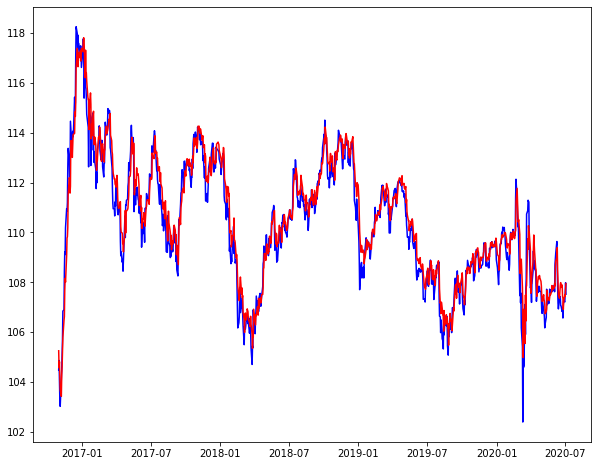

In [22]:
plt.figure(figsize=(10,8))
plt.plot(df_train_duration, train['open'][window_len:], label='Actual', color='blue')
plt.plot(df_train_duration,
         ((np.transpose(yen_model.predict(X_train))+1) * train['open'].values[:-window_len])[0], label='Predicted', color='red')
plt.show()

## 訓練データの期間 + テストデータの期間

990


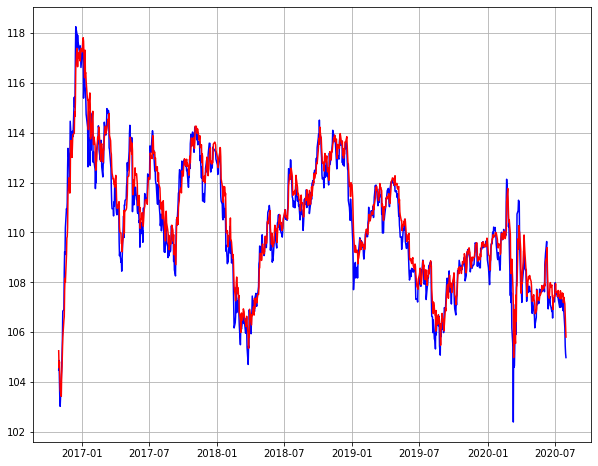

In [23]:
df_train_duration = df["time"][window_len:]
print(len(df_train_duration))

plt.figure(figsize=(10,8))
plt.plot(df_train_duration, all_data['open'][window_len:], label='Actual', color='blue')
plt.plot(df_train_duration,
         ((np.transpose(yen_model.predict(all_data_lstm_in))+1) * all_data['open'].values[:-window_len])[0], label='Predicted', color='red')

plt.grid()
plt.show()

## テストデータの区間

20


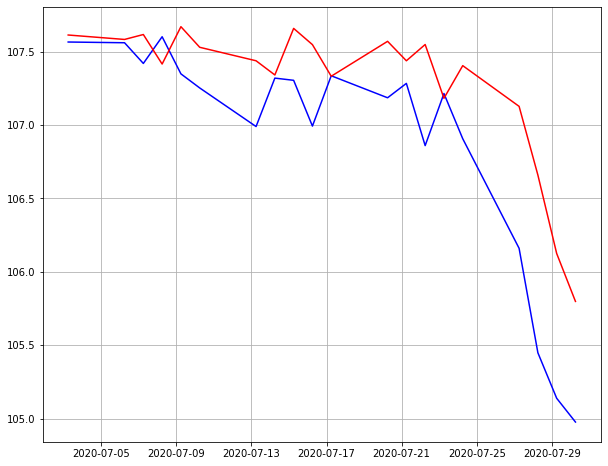

In [24]:
df_train_duration = df["time"].tail(len(test))
print(len(df_train_duration))

plt.figure(figsize=(10,8))
plt.plot(df_train_duration, all_data['open'].tail(len(df_train_duration)), label='Actual', color='blue')

_temp_pred = ((np.transpose(yen_model.predict(all_data_lstm_in))+1) * all_data['open'].values[:-window_len])[0]
plt.plot(df_train_duration, _temp_pred[970:], label='Predicted', color='red')

plt.grid()
plt.show()

## テストデータ + 予測結果

In [25]:
# 予測結果
pred = (((np.transpose(yen_model.predict(latest_lstm_in))+1) * latest['open'].values[0])[0])[0]
print(pred)

105.75925


In [26]:
"""
t_test = df.iloc[980]["time"]

tdatetime = t_test
tstr = tdatetime.strftime('%Y/%m/%d %H:%M:%S')
"""

'\nt_test = df.iloc[980]["time"]\n\ntdatetime = t_test\ntstr = tdatetime.strftime(\'%Y/%m/%d %H:%M:%S\')\n'

In [495]:
#df_train_duration_future = df_train_duration.append(tdatetime)
#print(df_train_duration_future)

20


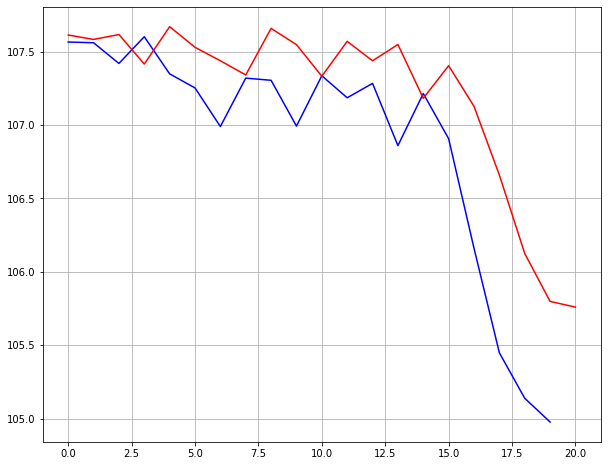

In [27]:
df_train_duration = df["time"].tail(len(test))
print(len(df_train_duration))

plt.figure(figsize=(10,8))
#plt.plot(df_train_duration, all_data['open'].tail(len(df_train_duration)), label='Actual', color='blue')
plt.plot(np.arange(len(df_train_duration)), all_data['open'].tail(len(df_train_duration)), label='Actual', color='blue')

# 推測
_temp_pred = ((np.transpose(yen_model.predict(all_data_lstm_in))+1) * all_data['open'].values[:-window_len])[0]
_temp_pred_future = np.append(_temp_pred, pred)

plt.plot(np.arange(len(df_train_duration)+1), _temp_pred_future[970:], label='Predicted', color='red')

plt.grid()
plt.show()